In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


In [55]:
class ConditionalGenerator(nn.Module):
    def __init__(self, z_dim=100, label_dim=10, img_dim=784):
        super().__init__()
        self.label_embedding = nn.Embedding(label_dim, label_dim)
        self.net = nn.Sequential(
            nn.Linear(z_dim + label_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Embed and concatenate
        label_embed = self.label_embedding(labels)
        x = torch.cat([z, label_embed], dim=1)
        return self.net(x).view(-1, 1, 28, 28)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, label_dim=10, img_dim=784):
        super().__init__()
        self.label_embedding = nn.Embedding(label_dim, label_dim)
        self.net = nn.Sequential(
            nn.Linear(img_dim + label_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        x = img.view(img.size(0), -1)  # flatten image
        label_embed = self.label_embedding(labels)
        x = torch.cat([x, label_embed], dim=1)
        return self.net(x)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100
G = ConditionalGenerator(z_dim).to(device)
D = ConditionalDiscriminator().to(device)
criterion = nn.BCELoss()

optimizer_G = torch.optim.Adam(G.parameters(), lr=3.5e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)

G.apply(weights_init)
D.apply(weights_init)

n_critic = 5 
for epoch in range(25):
    for i, (real_imgs, labels) in enumerate(dataloader):
        batch_size = real_imgs.size(0)
        real_imgs, labels = real_imgs.to(device), labels.to(device)

        # Real and fake labels
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # -----------------
        # Train Discriminator
        # -----------------
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z, labels)
        d_real = D(real_imgs, labels)
        d_fake = D(fake_imgs.detach(), labels)
        d_loss = criterion(d_real, real) + criterion(d_fake, fake)

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        if i % n_critic == 0:
            z = torch.randn(batch_size, z_dim).to(device)
            fake_imgs = G(z, labels)
            d_fake = D(fake_imgs, labels)
            # g_loss = criterion(d_fake, real)  # or non-saturating loss
            g_loss = -torch.mean(torch.log(d_fake + 1e-8)) 

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

        # z = torch.randn(batch_size, z_dim).to(device)
        # fake_imgs = G(z, labels)
        # d_fake = D(fake_imgs, labels)
        # g_loss = criterion(d_fake, real)

        # optimizer_G.zero_grad()
        # g_loss.backward()
        # optimizer_G.step()

        # if epoch % 5 == 0:
        #     with torch.no_grad():
        #         samples = G(fixed_z, fixed_labels).detach().cpu()
        #         grid = make_grid(samples, nrow=10, normalize=True)
        #         save_image(grid, f'epoch_{epoch}.png')


    print(f"[{epoch}] D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")


[0] D_loss: 0.2804, G_loss: 3.4257
[1] D_loss: 0.0309, G_loss: 4.5732
[2] D_loss: 0.1007, G_loss: 4.0853
[3] D_loss: 0.1537, G_loss: 11.9653
[4] D_loss: 0.1656, G_loss: 4.6340
[5] D_loss: 0.1852, G_loss: 6.1455
[6] D_loss: 0.0866, G_loss: 5.6290
[7] D_loss: 0.6873, G_loss: 4.3094
[8] D_loss: 0.0160, G_loss: 8.0374
[9] D_loss: 0.1582, G_loss: 4.8170
[10] D_loss: 0.3240, G_loss: 6.8614
[11] D_loss: 0.0444, G_loss: 5.5349
[12] D_loss: 0.0378, G_loss: 4.2706
[13] D_loss: 0.1260, G_loss: 4.3784
[14] D_loss: 0.2772, G_loss: 2.1735
[15] D_loss: 0.1699, G_loss: 4.3521
[16] D_loss: 0.0784, G_loss: 3.9783
[17] D_loss: 0.2259, G_loss: 4.6653
[18] D_loss: 2.1279, G_loss: 7.6949
[19] D_loss: 0.2893, G_loss: 8.7645
[20] D_loss: 0.1388, G_loss: 3.0706
[21] D_loss: 0.4791, G_loss: 2.7528
[22] D_loss: 0.3226, G_loss: 2.9350
[23] D_loss: 0.2532, G_loss: 6.6692
[24] D_loss: 0.6534, G_loss: 4.2102


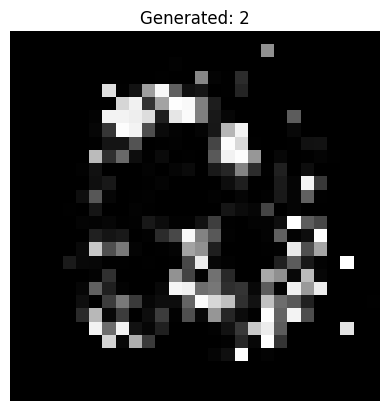

In [333]:
import matplotlib.pyplot as plt

def generate_digit(label):
    G.eval()
    z = torch.randn(1, z_dim).to(device)
    label = torch.tensor([label]).to(device)
    with torch.no_grad():
        fake_img = G(z, label).cpu().squeeze().numpy()
        plt.imshow(fake_img, cmap='gray')
        plt.title(f"Generated: {label.item()}")
        plt.axis("off")
        plt.show()

generate_digit(2)